## FUNSD Dataset Exploration

##### Code heavily depends on this notebook:
https://www.kaggle.com/code/lonelvino/funsd-analyse-dataset#2.4-Evaluation

In [ ]:
import os
import glob
import json
import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
train_dir = "training_data"
test_dir = "testing_data"

train_image_files = sorted(glob.glob(f"{train_dir}/images/*"))
test_image_files = sorted(glob.glob(f"{test_dir}/images/*"))
train_annotation_files = sorted(glob.glob(f"{train_dir}/annotations/*"))
test_annotation_files = sorted(glob.glob(f"{test_dir}/annotations/*"))

print(f"Number of training images: {len(train_image_files)}. Number of training annotations: {len(train_annotation_files)}.")
print(f"Number of testing images: {len(test_image_files)}. Number of testing annotations: {len(test_annotation_files)}.")


Number of training images: 149. Number of training annotations: 149.
Number of testing images: 50. Number of testing annotations: 50.


In [3]:
RED = [0, 0, 225]
GREEN = [0,255, 0]
BLUE = [255,0, 0]
CYAN = [255, 255, 0]
label_to_color = {"question": RED, "answer": GREEN, "header": BLUE, "other": CYAN}

In [4]:
def color_image(image, annotation):
    for entity in annotation.entities:
        box = entity.box
        image_crop = image[box.ymin:box.ymax, box.xmin:box.xmax, :]
        image_crop[np.where((image_crop < [127,127,127]).all(axis = 2))] = label_to_color[entity.label]
        image[box.ymin:box.ymax, box.xmin:box.xmax, :] = image_crop
        
    return image

In [5]:
def load_images(img_path, annotations):
    imgs_org = []; imgs_colored = []
    for idx, image_file in enumerate(img_path):
        imgs_org.append(cv2.imread(image_file))
        imgs_colored.append(color_image(cv2.imread(image_file), annotations[idx]))
    return imgs_org, imgs_colored   

In [6]:
class Box():
    def __init__(self, xmin, ymin, xmax, ymax):
        self.xmin, self.ymin, self.xmax, self.ymax = xmin, ymin, xmax, ymax
     
    def __repr__(self):
        return f"Box(xmin={self.xmin},ymin={self.ymin}, xmax={self.xmax}, ymax={self.ymax})"

class Word:
    def __init__(self, box, text):
        self.box = Box(*box)
        self.text = text
        
    def __getitem__(self, item):
        if not hasattr(self, item):
            raise KeyError(f"{item} is not present in {self.__class__}")
        return getattr(self, item)
    
    def __repr__(self):
        return f"Word(box={self.box}, text={self.text})"
        
    
class Entity:
    def __init__(self,box, text, label, words, linking, id):
        self.id_ = id
        self.box = Box(*box)
        self.text = text
        self.label = label
        self.words = [ Word(**word) for word in words ] 
        self.linking = linking
    
    def __getitem__(self, item):
        if not hasattr(self, item):
            raise KeyError(f"{item} is not present in {self.__class__}")
        return getattr(self, item)
    
    def __repr__(self):
        return f"Entity(id_={self.id_}, box={self.box}, text={self.text}, label={self.label}, words={self.words}, linking={self.linking})"
    
class Form():
    def __init__(self, entities):
        self.entities = [Entity(**entity) for entity in entities]
        
    def __repr__(self):
        return f"Form(entities={self.entities})"

In [7]:
def load_annotations(annotations_name):
    annotations = []
    for path in annotations_name:
        with open(path, encoding="utf-8") as fp:
            annotations.append(Form(json.loads(fp.read())["form"]))
    return annotations

In [8]:
ann_train = load_annotations(train_annotation_files)
img_train_org, img_train_colored = load_images(train_image_files, ann_train)
ann_test = load_annotations(test_annotation_files)
img_test_org, img_test_colored = load_images(test_image_files, ann_test)

In [9]:
import math
import random 
def disp_multi_images(images, suptitle=''):
    len_images = len(images) if len(images)<=25 else 25
    num = math.ceil(math.sqrt(len_images))
    idxs = random.sample(range(0, len(images)), len_images)
    
    fig = plt.figure(figsize=(num**3,num**3)) if num > 3 else  plt.figure(figsize=((num+1)**3,(num+1)**3))
    plt.suptitle(suptitle, size=16, y=3)
    
    for count, index in enumerate(idxs):
        ax = fig.add_subplot(num, num, count + 1, xticks=[], yticks=[])
        image = images[index]
        ax.imshow(image)
        
        if count==len_images-1:
            plt.show()
            break    

In [11]:
from copy import copy

num_train = {"forms": len(ann_train), "words": 0, "entities":0, \
             "question": 0, "header": 0, "answer": 0, "other": 0}
num_test = copy(num_train); num_test['forms'] = len(ann_test)
for annotation in ann_train:
    num_train["entities"] += len(annotation.entities)
    for entity in annotation.entities:
        num_train[entity.label] += 1
        num_train['words'] += len(entity.words)

for annotation in ann_test:
    num_test["entities"] += len(annotation.entities)
    for entity in annotation.entities:
        num_test[entity.label] += 1
        num_test['words'] += len(entity.words)

In [16]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
            dict_3[key] = [value , dict_1[key]]
    return dict_3

num_label = mergeDictionary(num_train, num_test)
print(pd.DataFrame(num_label, index=['Testing', 'Training']))

          forms  words  entities  question  header  answer  other
Testing      50   8973      2332      1077     122     821    312
Training    149  22512      7411      3266     441    2802    902


Text(0.5, 1.0, 'Colored Image')

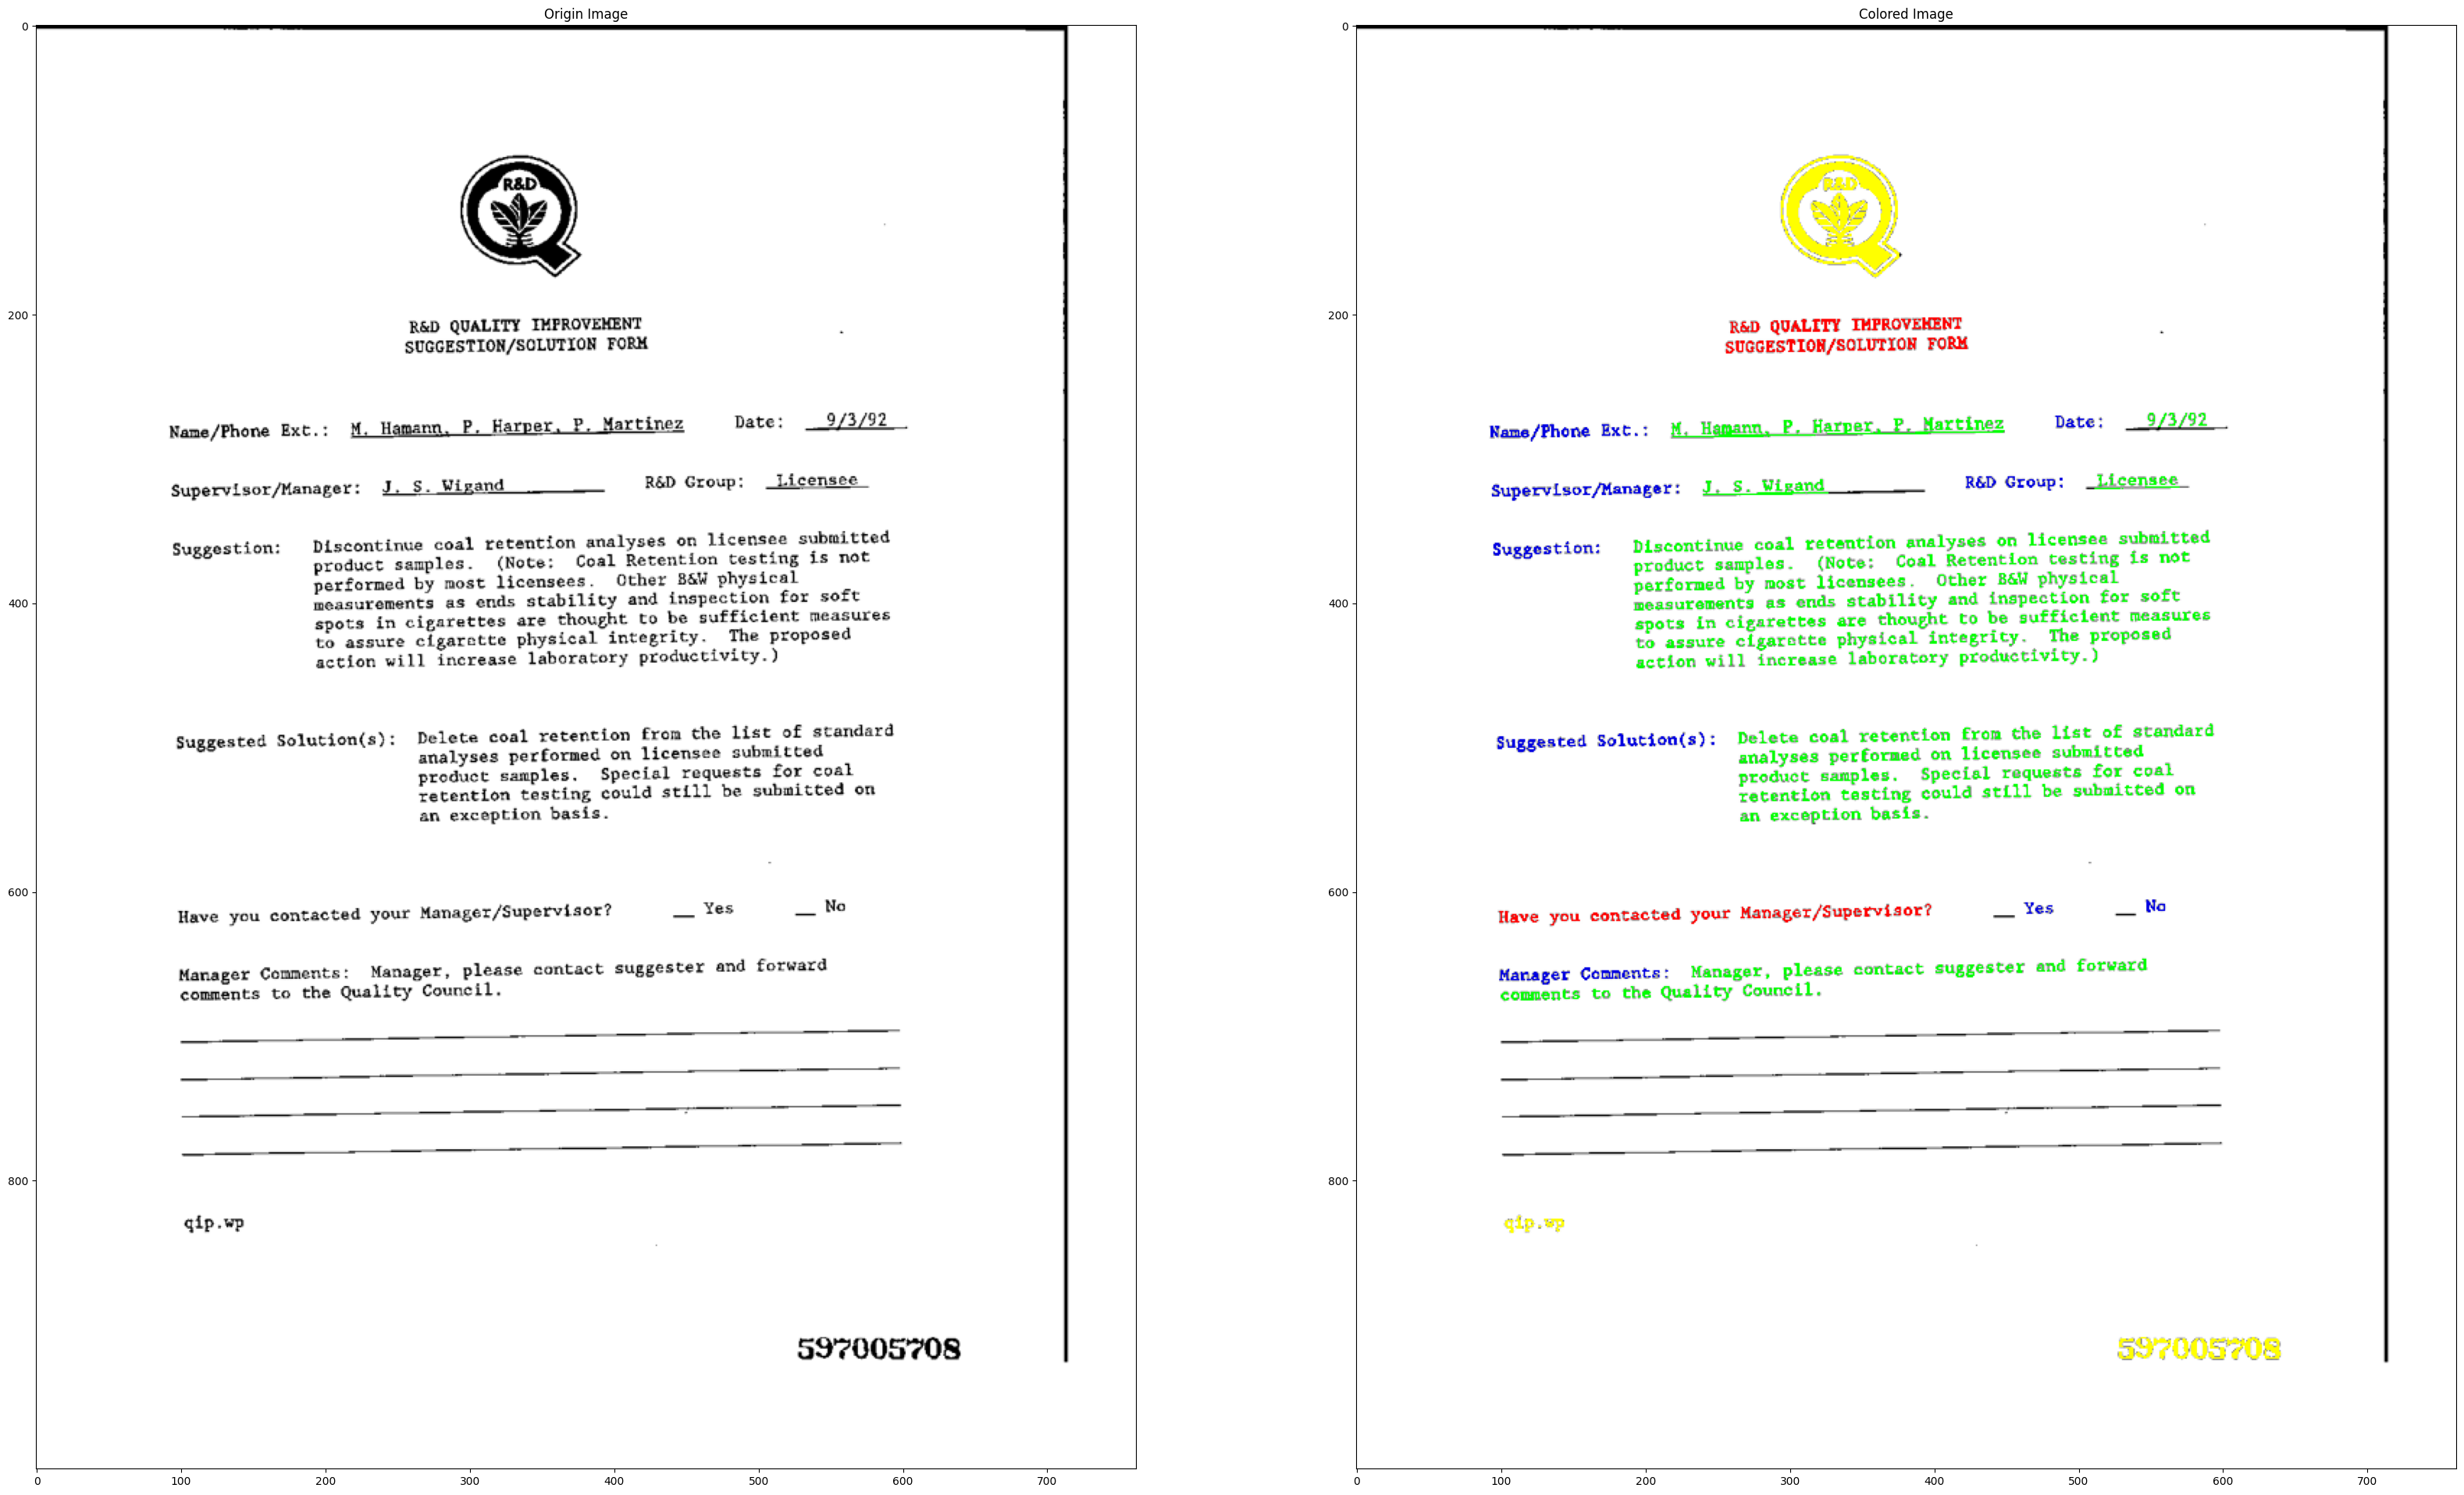

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40,40))
axes[0].imshow(img_train_org[0])
axes[0].set_title('Origin Image')
axes[1].imshow(img_train_colored[0])
axes[1].set_title('Colored Image')

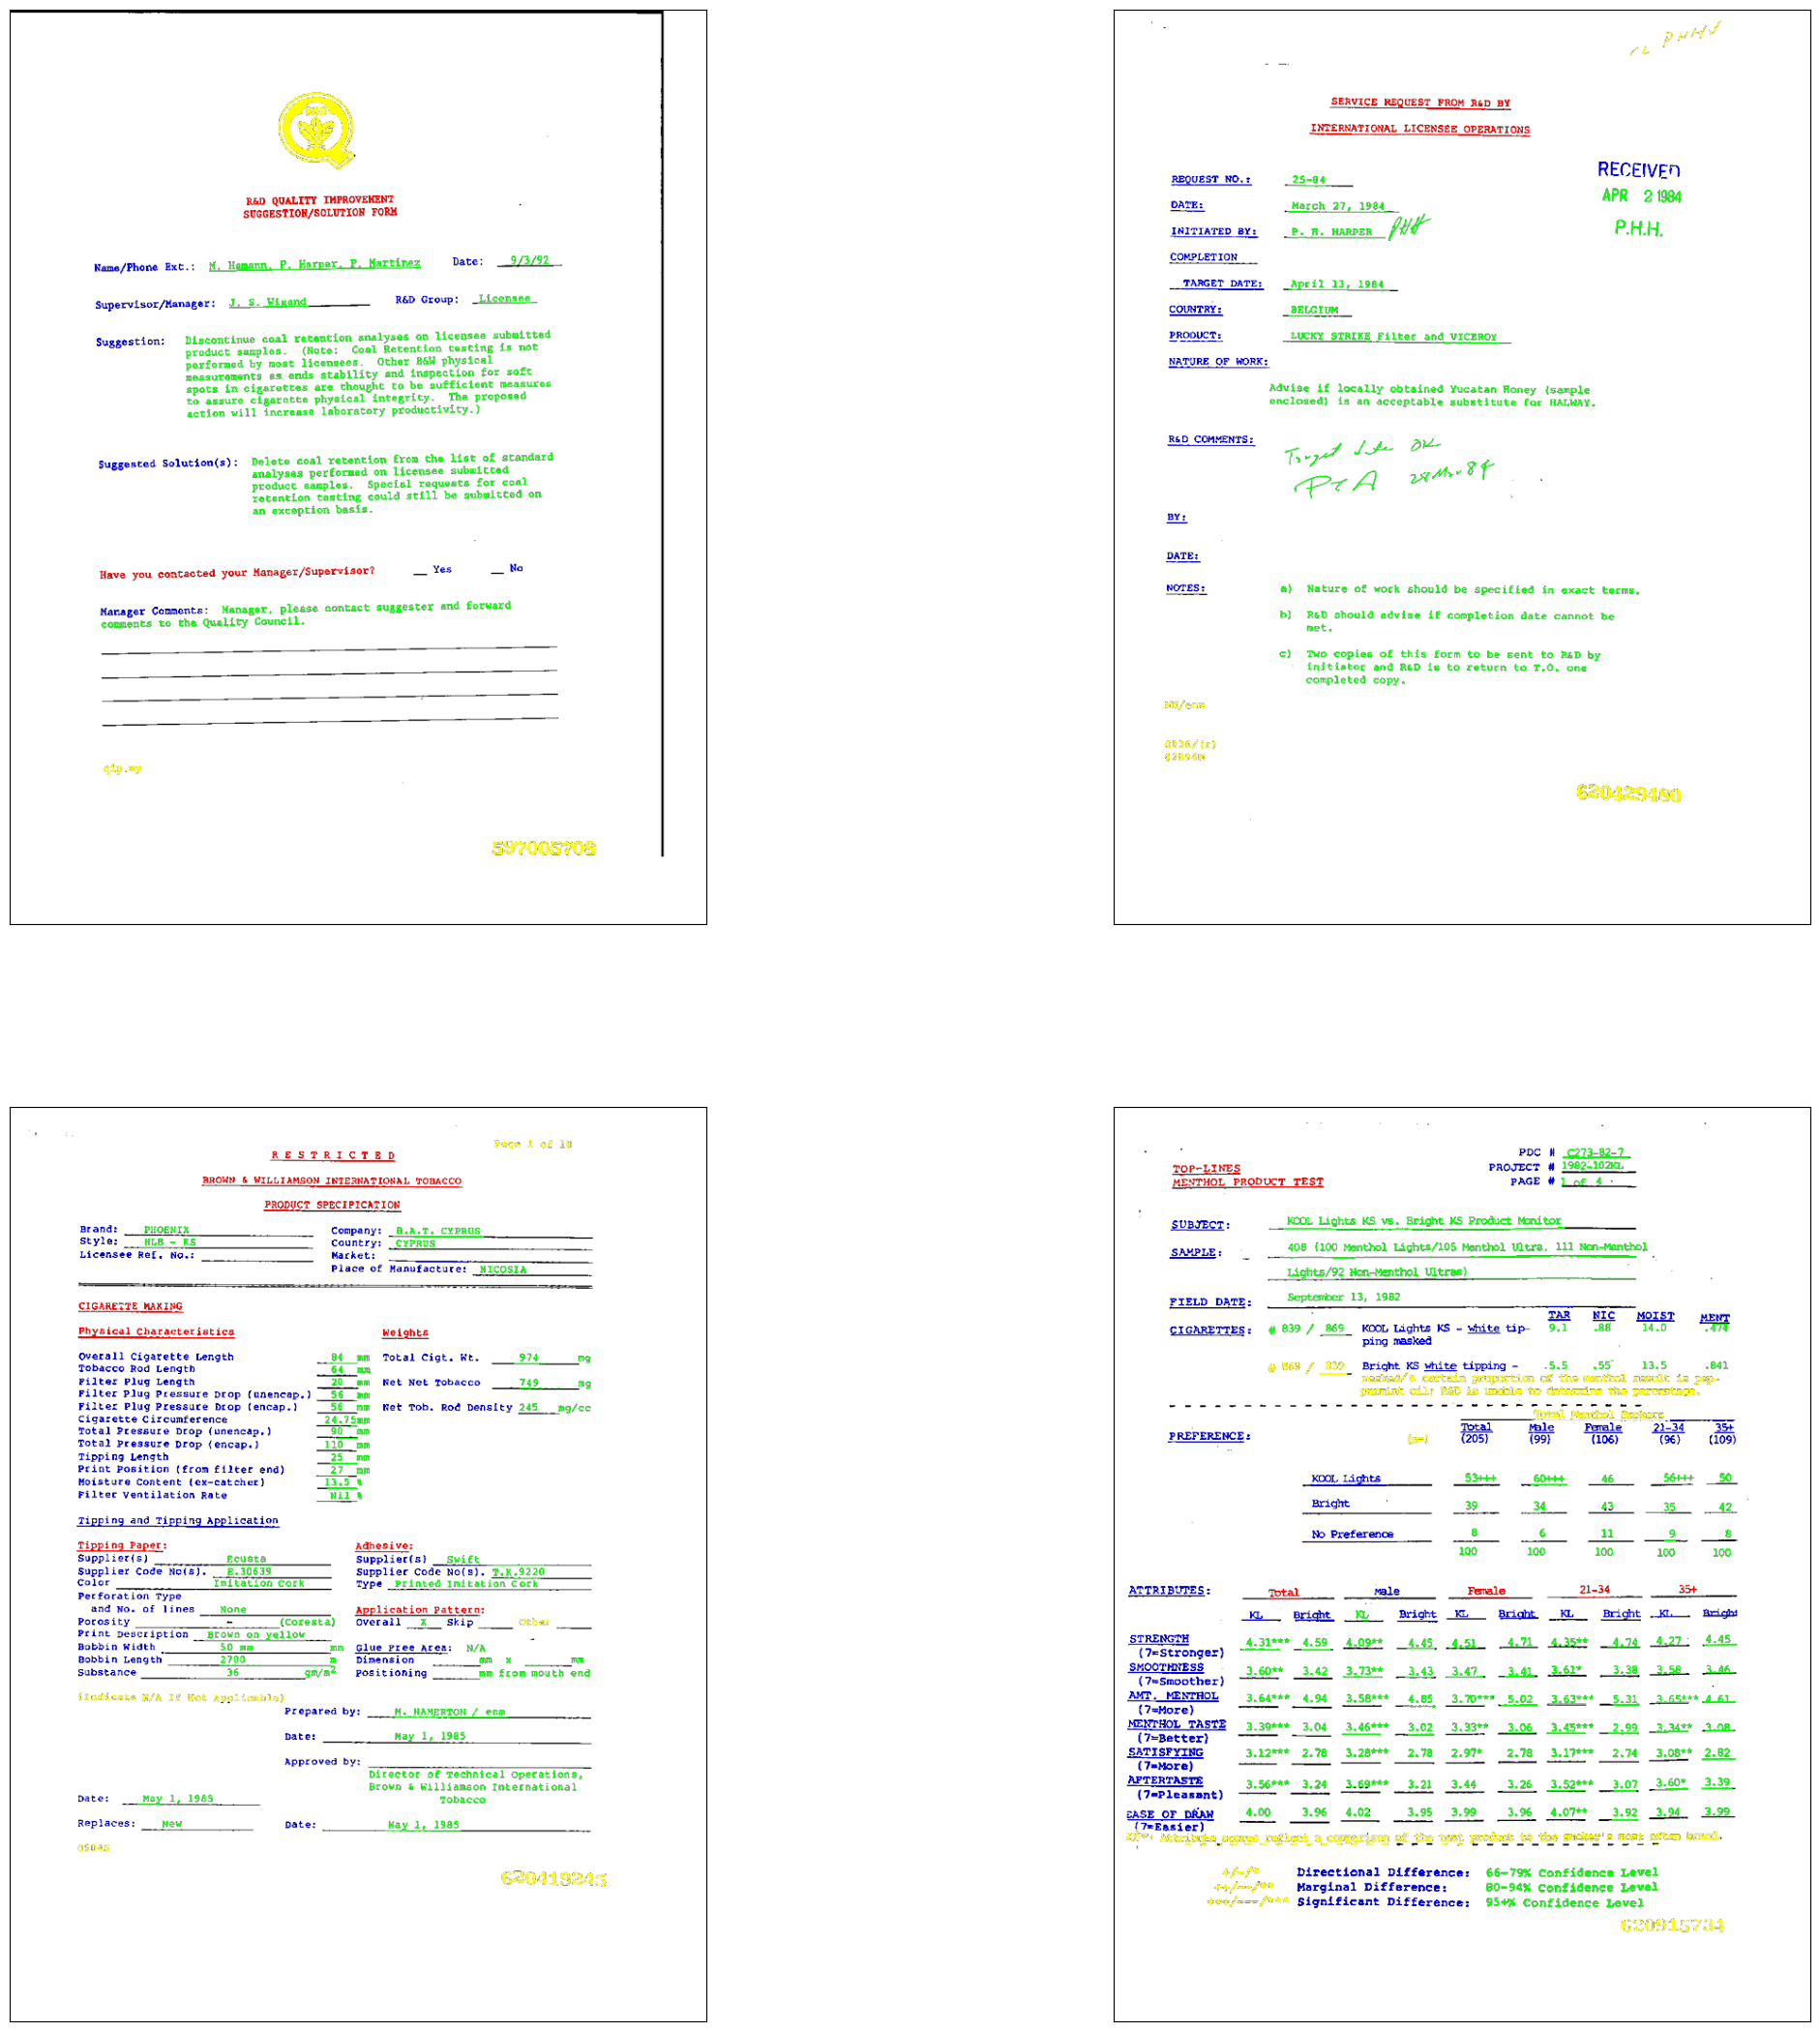

In [15]:
disp_multi_images(img_train_colored[:4])
